In [252]:
# Importing dependencies
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors

def generate_plot(graph):
    fig, ax = ox.plot_graph(graph, node_color='blue', edge_linewidth=2, bgcolor='white', show=False)

    # Add label with road length (m)
    for u, v, key, data in graph.edges(keys=True, data=True):
        if 'length' in data:
            # Compute the midpoint of the edge
            x1, y1 = graph.nodes[u]['x'], graph.nodes[u]['y']
            x2, y2 = graph.nodes[v]['x'], graph.nodes[v]['y']
            mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
            
            # Round the length to whole number
            label = str(round(data['length']))
            ax.text(mid_x, mid_y, label, color='black', size=10, ha='center', va='center')

    ox.plot_graph(graph, save=True, filepath='map.png', node_color='blue', edge_linewidth=2, bgcolor='white', show=False, ax=ax)

def animate_graph_traversal(graph, traversal_path, filename='traversal.gif'):
    fig, ax = ox.plot_graph(graph, node_color='none', edge_color='gray', show=False, close=False)

    # A dictionary to store the count of traversals for each edge
    edge_counts = {(u, v): 0 for u, v in graph.edges()}

    # The colormap to convert traversal counts to colors
    cmap = plt.get_cmap('plasma')

    def update(frame):
        u, v = traversal_path[frame]

        # Increase the count for the edge
        if (u, v) in edge_counts:
            edge_counts[(u, v)] += 1
        else:
            edge_counts[(v, u)] += 1

        # Determine the color for the edge based on its traversal count
        max_count = max(edge_counts.values())
        if (u, v) in edge_counts:
            rgba_color = cmap(edge_counts[(u, v)] / max_count)
        else:
            rgba_color = cmap(edge_counts[(v, u)] / max_count)

        # Convert RGBA to HEX
        hex_color = mcolors.to_hex(rgba_color)

        ox.plot_graph_route(graph, [u, v], route_linewidth=2, node_size=2, bgcolor='white', route_color=hex_color, ax=ax)

    ani = FuncAnimation(fig, update, frames=len(traversal_path), repeat=False)

    # Save the animation as GIF
    ani.save(filename, writer='pillow', fps=3)

    plt.close(fig)

def dijkstra(graph, start, end):
    # Initialize distances for all vertices to infinity
    distances = {vertex: float('infinity') for vertex in graph}
    distances[start] = 0 # starting vertex to 0

    predecessors = {vertex: None for vertex in graph}
    queue = [(0, start)]

    # Continue until all vertices have been visited
    while queue:
        current_distance, current_vertex = min(queue, key=lambda x: x[0])
        queue.remove((current_distance, current_vertex))

        for neighbor in graph[current_vertex]:
            weight = graph[current_vertex][neighbor][0]['length']
            distance = current_distance + weight

            if distance < distances[neighbor]:
                distances[neighbor] = distance
                predecessors[neighbor] = current_vertex
                queue.append((distance, neighbor))

    # Backtrack to get the path from start to end
    path = []
    while end and predecessors[end] is not None:
        path.append((predecessors[end], end))
        end = predecessors[end]

    path.reverse()

    return path

def compare_graphs_by_connected_edges(graph1, graph2):
    # Compare edge sets
    if set(graph1.edges()) == set(graph2.edges()):
        print('[OK] Graphs have identical connected edges')
        return True

    print('[FAIL] Graphs DO NOT have identical connected edges')
    return False


In [253]:
# Download the road network graph
lat, lon = 56.958141067669146, 24.12462850613549
directed_graph = ox.graph_from_point((lat, lon), dist=500, network_type='drive') # Get surrounding area in N meter radius

In [254]:
# Remove road directions to get undirected graph
graph = directed_graph.to_undirected()

In [255]:
# Select largest connected graph
largest_connected_component = max(nx.connected_components(graph), key=len)
graph = graph.subgraph(largest_connected_component).copy()

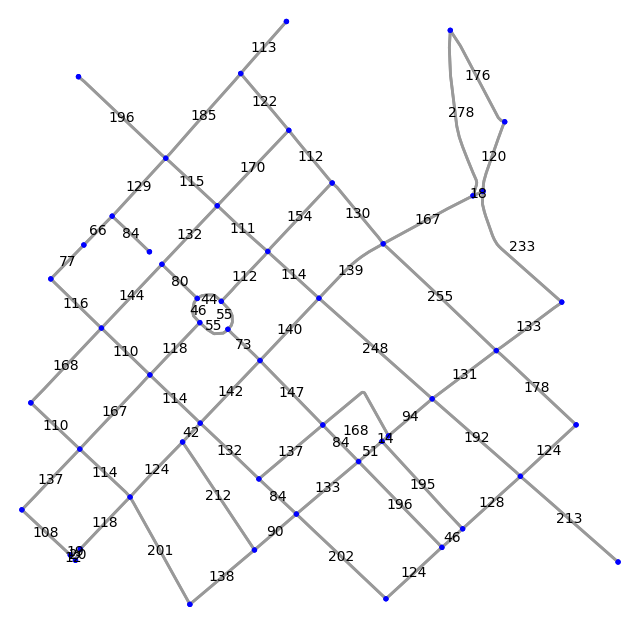

In [256]:
# Generate plot to verify that graph is suitable
generate_plot(graph)

In [257]:
# Given two nodes u and v from source_graph, copy the edge and its attributes to target_graph
# Update path_length, traversed_edges and solution_path
def copy_edge_to_solution(u, v, source_graph, target_graph, solution_path, traversed_edges, path_length):
    solution_path.append((u, v))
    traversed_edges.add((u, v))
    traversed_edges.add((v, u))

    path_length += source_graph[u][v][0]['length']

    data = source_graph[u][v][0]
    target_graph.add_edge(u, v, **data)

In [258]:
# Generate initial (likely unoptimal) feasible solution
def generate_initial_solution(graph):
    path_length = 0
    solution_path = []
    traversed_edges = set()

    # Configure solution graph
    solution_graph = nx.MultiDiGraph() # Directed graph
    solution_graph.graph['crs'] = graph.graph['crs']
    solution_graph.add_nodes_from(graph.nodes(data=True)) # Copy all nodes (without edges)

    # Start from a random vertex
    # TODO: choice could be optimized
    start_vertex = random.choice(list(graph.nodes))
    edge_count = graph.number_of_edges()

    # Keep track of path to backtrack our steps
    path = [start_vertex]

    # While there are nodes in path and while not all graph edges were traversed
    while path and len(traversed_edges) < 2 * edge_count:
        current_vertex = path[-1] # get the most recent node in path

        neighbor_vertices = list(graph.neighbors(current_vertex))
        unvisited_neighbors = [n for n in neighbor_vertices if (current_vertex, n) not in traversed_edges and (n, current_vertex) not in traversed_edges]

        if unvisited_neighbors:
            # Get neighbor with the smallest amount of neighbors
            sorted_neighbors = sorted(unvisited_neighbors, key=lambda x: len(list(graph.neighbors(x))))
            next_vertex = sorted_neighbors[0]

            # Add the edge to the solution graph
            copy_edge_to_solution(current_vertex, next_vertex, graph, solution_graph, solution_path, traversed_edges, path_length)

            # Debugging
            # fig, ax = ox.plot_graph(solution_graph, node_color='gray', edge_linewidth=2, bgcolor='white', show=True)

            path.append(next_vertex)
        else:
            path.pop()  # backtrack
            backstep_vertex = path[-1]

            if path:
                # Add the edge to the solution graph
                copy_edge_to_solution(current_vertex, backstep_vertex, graph, solution_graph, solution_path, traversed_edges, path_length)

    if solution_path[-1][1] != solution_path[1][0]:
        new_edges = dijkstra(graph, solution_path[-1][1], solution_path[0][0])
        for edge in new_edges:
                solution_path.append(edge)

    return solution_graph, solution_path, path_length

init_graph, init_path, init_length = generate_initial_solution(graph)
compare_graphs_by_connected_edges(graph, init_graph.to_undirected())

[OK] Graphs have identical connected edges


True

In [259]:
print('How the path looks:\n')
print(init_path)

How the path looks:

[(5132471117, 409108466), (409108466, 31200174), (31200174, 26609175), (26609175, 26609133), (26609133, 26609129), (26609129, 26639009), (26639009, 27023891), (27023891, 26639010), (26639010, 534396308), (534396308, 26639010), (26639010, 26609130), (26609130, 26609128), (26609128, 26609130), (26609130, 510182220), (510182220, 510182256), (510182256, 510182220), (510182220, 27642570), (27642570, 26625326), (26625326, 26663804), (26663804, 26663806), (26663806, 26695888), (26695888, 26695886), (26695886, 9371194253), (9371194253, 9371194252), (9371194252, 9371194259), (9371194259, 9371194253), (9371194253, 9371194259), (9371194259, 26678577), (26678577, 26852740), (26852740, 29029081), (29029081, 29029083), (29029083, 26609164), (26609164, 31200176), (31200176, 26609186), (26609186, 5132471114), (5132471114, 5132471116), (5132471116, 5132471117), (5132471117, 5132471118), (5132471118, 26609166), (26609166, 5132471118), (5132471118, 5132471119), (5132471119, 27023890)

In [260]:
from collections import defaultdict

class Solution:
    def __init__(self, graph, given_solution_path, start_vertex):
        self.length = 0 # Path length
        self.original_graph = graph
        self.given_solution_path = given_solution_path

        # Final results are stored here
        self.path = []

        self.start_vertex = start_vertex

        self.traversed_edges = set() # Keep track of traversed edges. When edge (u,v) is traversed, edge (v,u) is also added
        self.traversal_stack = [start_vertex] # While traversing randomly through graph, helps to trace the path back

        # Iterators
        self.current_vertex = start_vertex
        self.next_vertex = None
        self.unvisited_neighbors = [] # Unvisited neighbor vertices
        self.neighbor_vertices = [] # Current vertex neighbors

    # Since self.traversed_edges edges counted twice, final solution would be twice bigger than original graph
    def has_traversed_all_edges(self):
        return len(self.traversed_edges) < 2 * self.original_graph.number_of_edges()

    # Searhing for solution while traversal stack is not empty or all edges were traversed
    def search_in_progress(self):
        return self.traversal_stack and self.has_traversed_all_edges()

    def get_neighbor_vertices(self):
        return list(self.original_graph.neighbors(self.current_vertex))

    def set_unvisited_neighbors(self):
        self.neighbor_vertices = self.get_neighbor_vertices()
        self.unvisited_neighbors =  [n for n in self.neighbor_vertices if (self.current_vertex, n) not in self.traversed_edges and (n, self.current_vertex) not in self.traversed_edges]

    def set_random_next_vertex(self):
        # Prioritize unvisited neighbors
        if self.unvisited_neighbors:
            self.next_vertex = random.choice(self.unvisited_neighbors)
        else:
            self.next_vertex = random.choice(self.neighbor_vertices)

    def add_edge_to_solution(self, u, v):
        self.path.append((u, v))
        self.traversed_edges.add((u, v))
        self.traversed_edges.add((v, u))

        self.length += round(self.original_graph[u][v][0]['length'])

    def get_last_stack_item(self):
        return self.traversal_stack[-1]

    def close_cycle(self):
        if self.path[0][0] != self.path[-1][1]:
            new_edges = dijkstra(self.original_graph, self.path[-1][1], self.path[0][0])
            for edge in new_edges:
                self.add_edge_to_solution(edge[0], edge[1])
                # self.path.append(edge)

def get_neighbors(graph, solution_path):
    """
    Generate neighboring solutions by traversing all unique vertices of multiedges.
    """
    neighbor_solutions = []
    unique_multiedge_vertices = get_unique_multiedge_vertices(solution_path)

    if not unique_multiedge_vertices:
        return solution_path

    for start_vertex in unique_multiedge_vertices:
        # sleep(0.01)
        solution = Solution(graph, solution_path, start_vertex)

        while solution.search_in_progress():
            solution.set_unvisited_neighbors()
            solution.set_random_next_vertex()

            if solution.unvisited_neighbors:
                solution.add_edge_to_solution(solution.current_vertex, solution.next_vertex)
                solution.traversal_stack.append(solution.next_vertex)

                solution.current_vertex = solution.next_vertex
            else:
                solution.traversal_stack.pop()

                if solution.traversal_stack:
                    backstep_vertex = solution.get_last_stack_item()
                    solution.add_edge_to_solution(solution.current_vertex, backstep_vertex)
                    solution.current_vertex = backstep_vertex

        solution.close_cycle()

        neighbor_solutions.append(solution)

    return neighbor_solutions

def get_unique_multiedge_vertices(path):
    multiedges = get_multiedges(path)

    return set([v for edge in multiedges for v in edge])

def get_multiedges(path):
    edge_counts = defaultdict(int) # set default value of 0 for undefined
    # Count the occurrences of each edge (both directions)
    for edge in path:
        edge_counts[edge] += 1
        reverse_edge = (edge[1], edge[0])
        edge_counts[reverse_edge] += 1

    # Filter out edges that occur more than once
    # If there is no multiedges in solution, then solution is optimal
    multiedges = [edge for edge, count in edge_counts.items() if count > 1]

    return multiedges

# Adjust the tabu_search function slightly
def tabu_search(graph, init_path):
    current_path = best_path = init_path
    best_path_length = evaluate(graph, best_path)
    tabu_path_list = []
    total_iterations_since_best_solution = 0

    MAX_ITERATIONS = 1500
    TABU_LIST_SIZE = graph.number_of_nodes()*3
    MAX_FAILED_ITERATIONS = 500

    for iteration in range(MAX_ITERATIONS):
        neighbors = get_neighbors(graph, current_path)
        total_iterations_since_best_solution += 1

        # Filter out neighbors that are in the tabu list, but include better ones than the global best
        viable_neighbors = [s for s in neighbors if s.path not in tabu_path_list or s.length < best_path_length]

        if not viable_neighbors:
            break

        next_solution = min(viable_neighbors, key=lambda s: s.length)
        next_path = next_solution.path
        next_path_length = next_solution.length

        # Update the best solution
        if next_path_length < best_path_length:
            best_path = next_path
            best_path_length = next_path_length

            total_iterations_since_best_solution = 0 # reset value
            print(f'[Epoch {iteration}] New best solution length: {best_path_length}')

        # Update tabu list
        tabu_path_list.append(next_path)
        tabu_path_list = tabu_path_list[-TABU_LIST_SIZE:]  # Ensure that tabu_list doesn't exceed the size

        current_path = next_path

        # Abort after X failed iterations
        if total_iterations_since_best_solution >= MAX_FAILED_ITERATIONS:
            print(f'[!Stopping criteria detected!] Exiting algorithm')
            break

        if iteration % 100 == 0:
            print(f'---New epoch: {iteration}---')

    return best_path

def evaluate(graph, solution_path):
    distance = 0

    for u, v in solution_path:
        distance += round(graph[u][v][0]['length'])

    return distance

In [261]:
print(f'Initial solution length: {evaluate(graph, init_path)}')
# animate_graph_traversal(graph, init_path, 'init.gif') # Creates a visualization of the solution

Initial solution length: 15215


In [262]:
start = time.time()
best_path = tabu_search(graph, init_path)
end = time.time()
print(f'Elapsed time: {end-start} seconds')
print(f'Best found solution length: {evaluate(graph, best_path)} meters')
# animate_graph_traversal(graph, best_path, 'best.gif')

---New epoch: 0---
[Epoch 1] New best solution length: 14423
[Epoch 2] New best solution length: 14324
[Epoch 4] New best solution length: 14060
[Epoch 17] New best solution length: 12642
[Epoch 91] New best solution length: 12371
---New epoch: 100---
---New epoch: 200---
---New epoch: 300---
---New epoch: 400---
---New epoch: 500---
[Epoch 584] New best solution length: 12358
---New epoch: 600---
---New epoch: 700---
[Epoch 794] New best solution length: 11897
---New epoch: 800---
---New epoch: 900---
---New epoch: 1000---
---New epoch: 1100---
---New epoch: 1200---
[!Stopping criteria detected!] Exiting algorithm
Elapsed time: 176.66763710975647 seconds
Best found solution length: 11897 meters


In [263]:
def graph_description(graph):
    print('[Graph description]')
    print(f'Number of vertices: {graph.number_of_nodes()}')
    print(f'Number of edges: {graph.number_of_edges()}')
    print(f'Length sum of all edges: {sum(data["length"] for u, v, data in graph.edges(data=True))}')

def assess_solution_quality(graph, path):
    print(f'Has visited all graph edges (is feasible): {all_edges_traversed(graph, path)}')
    print(f'Path length: {evaluate(graph, path)} meters')
    print(f'Number of traversed edges: {len(path)}')
    print(f'Number of traversed duplicate edges: {count_duplicate_edges(path)}')

def all_edges_traversed(graph, path):
    traversed_edges = set()

    # Mark the traversed edges
    for edge in path:
        u, v = edge
        if not graph.has_edge(u, v):
            return False  # Edge not in graph
        traversed_edges.add(edge)

    # Check if all edges in the graph were traversed
    for u, v in graph.edges():
        if (u, v) not in traversed_edges and (v, u) not in traversed_edges:
            return False

    return True

def count_duplicate_edges(path):
    seen_edges = set()
    duplicates = 0

    for edge in path:
        reversed_edge = (edge[1], edge[0])
        if reversed_edge in seen_edges or edge in seen_edges:
            duplicates += 1
        else:
            seen_edges.add(edge)

    return duplicates

Has visited all graph edges (is feasible): True
Path length: 15215 meters
Number of traversed edges: 120
Number of traversed duplicate edges: 43


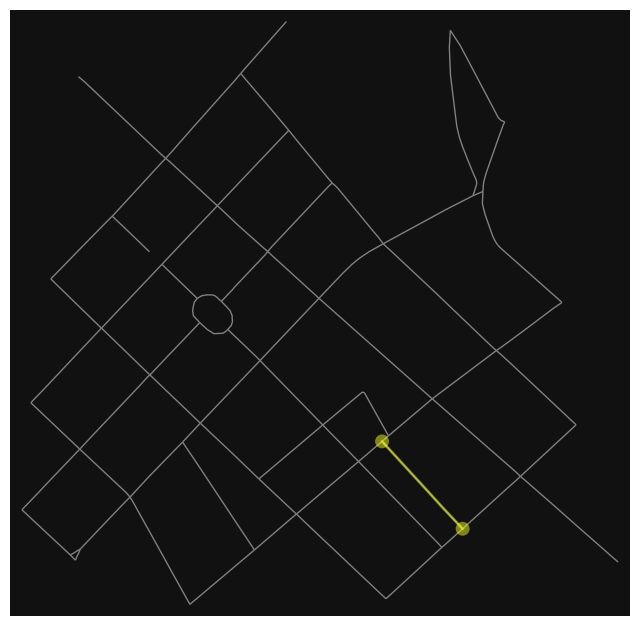

Has visited all graph edges (is feasible): True
Path length: 11897 meters
Number of traversed edges: 98
Number of traversed duplicate edges: 21


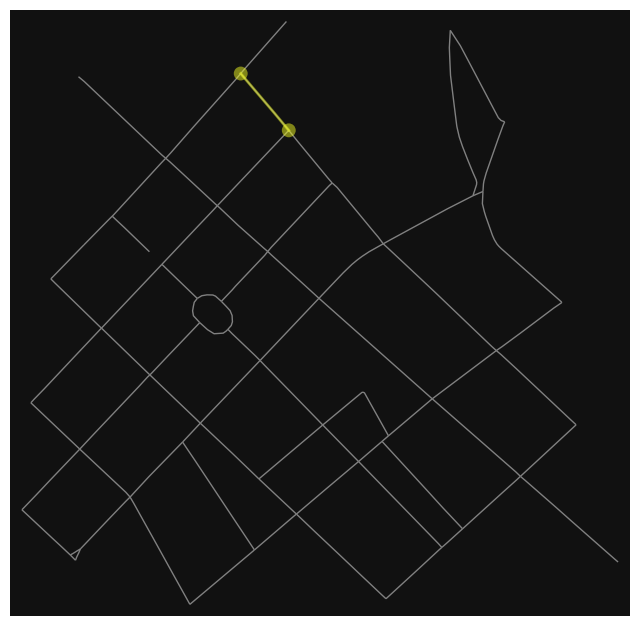

In [264]:
assess_solution_quality(graph, init_path)
animate_graph_traversal(graph, init_path, 'init.gif') # Creates a visualization of the solution

assess_solution_quality(graph, best_path)
animate_graph_traversal(graph, best_path, 'best.gif')

In [265]:
def test_solver(test_number, radius, flag_create_gifs=False):
    lat, lon = 56.958141067669146, 24.12462850613549

    directed_graph = ox.graph_from_point((lat, lon), dist=radius, network_type='drive')  # Get surrounding area in N meter radius

    # Remove road directions to get undirected graph
    graph = directed_graph.to_undirected()
    # Select largest connected graph
    largest_connected_component = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_connected_component).copy()
    graph_description(graph)
    init_graph, init_path, init_length = generate_initial_solution(graph)

    print('\n[Assessing quality of initial solution]')
    assess_solution_quality(graph, init_path)

    print('\n[Generating solution...]')
    start = time.time()
    best_path = tabu_search(graph, init_path)
    end = time.time()
    print(f'Best solution generation time: {end-start} seconds')

    print('\n[Assessing quality of best solution]')
    assess_solution_quality(graph, best_path)

    if flag_create_gifs:
        print('\n[Initial graph GIF]')
        animate_graph_traversal(graph, init_path, f'test_number_{test_number}_init.gif')

        print('\n[Best graph GIF]')
        animate_graph_traversal(graph, best_path, f'test_number_{test_number}_best.gif')

[Graph description]
Number of vertices: 26
Number of edges: 35
Length sum of all edges: 3963.181

[Assessing quality of initial solution]


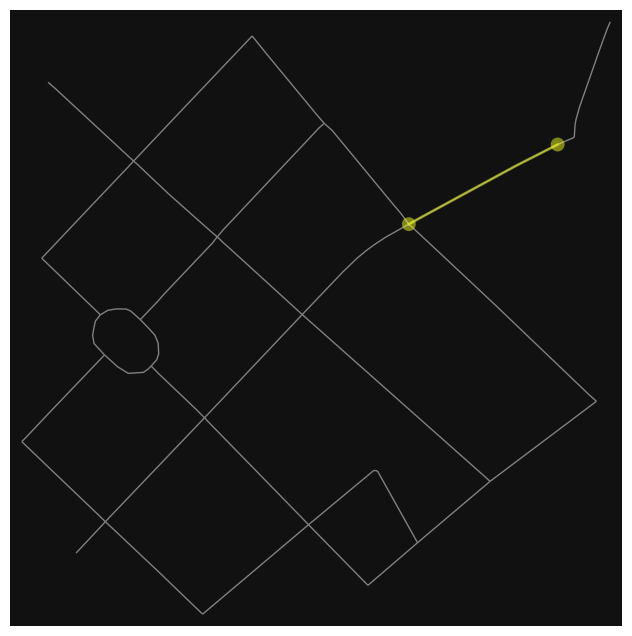

[(26609129, 26678576), (26678576, 678874676), (678874676, 5134398652), (5134398652, 678874676), (678874676, 26678576), (26678576, 26609129), (26609129, 27023890), (27023890, 26609175), (26609175, 31200174), (31200174, 409108466), (409108466, 26695911), (26695911, 31200173), (31200173, 31200176), (31200176, 26609164), (26609164, 29029083), (29029083, 26609164), (26609164, 26695890), (26695890, 26695910), (26695910, 26695895), (26695895, 27023894), (27023894, 27023892), (27023892, 26609130), (26609130, 27023892), (27023892, 27023891), (27023891, 26639009), (26639009, 26609129), (26609129, 26609133), (26609133, 26609175), (26609175, 26609133), (26609133, 26609136), (26609136, 26695897), (26695897, 26695900), (26695900, 26695895), (26695895, 26695900), (26695900, 34639066), (34639066, 26639009), (26639009, 34639066), (34639066, 26609133), (26609133, 34639066), (34639066, 27023892), (27023892, 34639066), (34639066, 26695900), (26695900, 26695897), (26695897, 26695910), (26695910, 26695897),

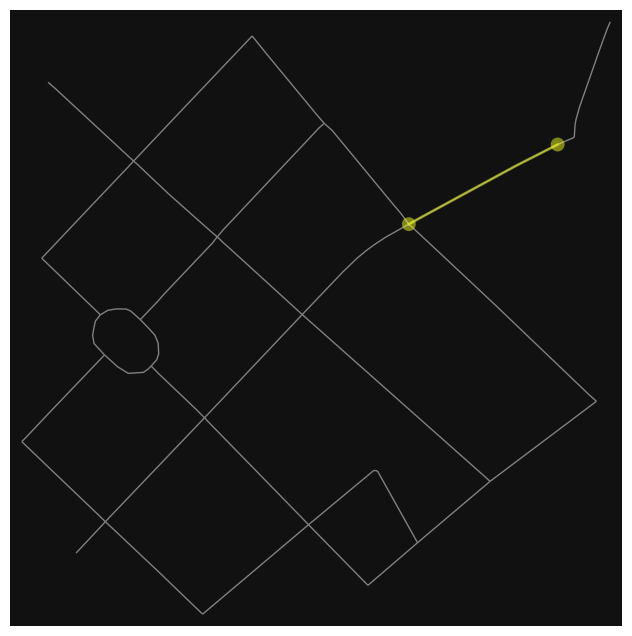


[Best graph GIF]


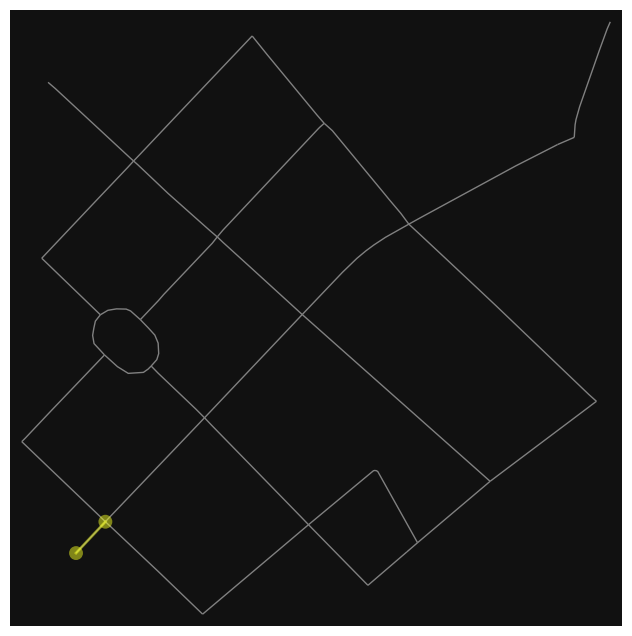

In [266]:
# Testing Nr1
# Radius from location = 300m
test_solver(1, 300, True)

[Graph description]
Number of vertices: 52
Number of edges: 77
Length sum of all edges: 9681.474

[Assessing quality of initial solution]


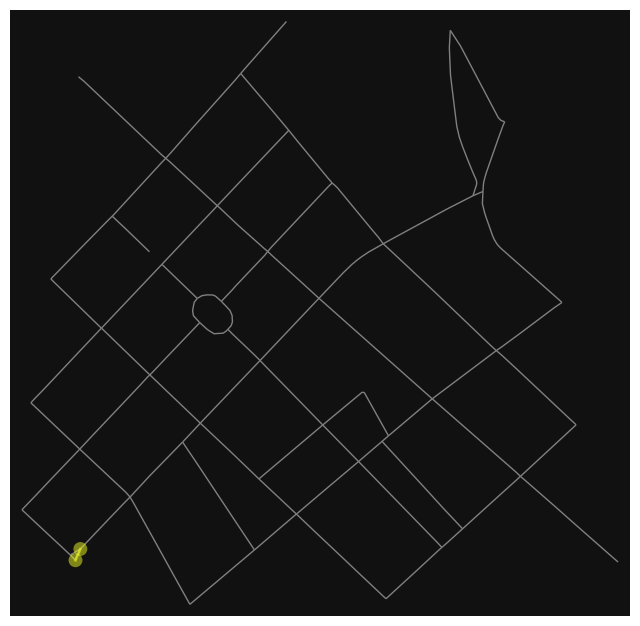

[(9371194259, 9371194252), (9371194252, 9371194253), (9371194253, 26695886), (26695886, 26695888), (26695888, 26663806), (26663806, 26663804), (26663804, 26625326), (26625326, 27642570), (27642570, 510182220), (510182220, 510182256), (510182256, 510182220), (510182220, 26609130), (26609130, 26609128), (26609128, 26609130), (26609130, 26639010), (26639010, 534396308), (534396308, 26639010), (26639010, 27023891), (27023891, 26639009), (26639009, 26609129), (26609129, 26678576), (26678576, 49241974), (49241974, 5134398652), (5134398652, 678874676), (678874676, 6920633424), (6920633424, 27023890), (27023890, 5132471119), (5132471119, 5132471118), (5132471118, 26609166), (26609166, 5132471118), (5132471118, 5132471117), (5132471117, 409108466), (409108466, 31200174), (31200174, 26609175), (26609175, 26609133), (26609133, 26609129), (26609129, 27023890), (27023890, 26609175), (26609175, 5132471118), (5132471118, 26609175), (26609175, 27023890), (27023890, 26609129), (26609129, 26609133), (26

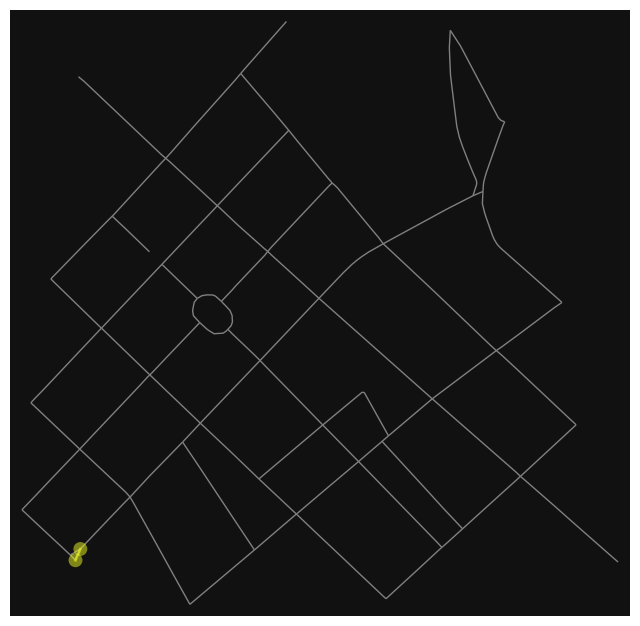


[Best graph GIF]


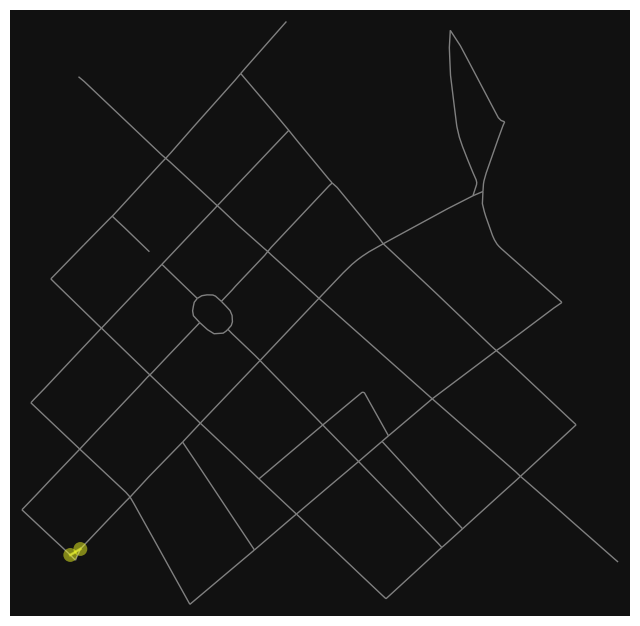

In [267]:
# Testing Nr2
# Radius from location = 500m
test_solver(2, 500, True)

[Graph description]
Number of vertices: 117
Number of edges: 175
Length sum of all edges: 23827.795999999988

[Assessing quality of initial solution]


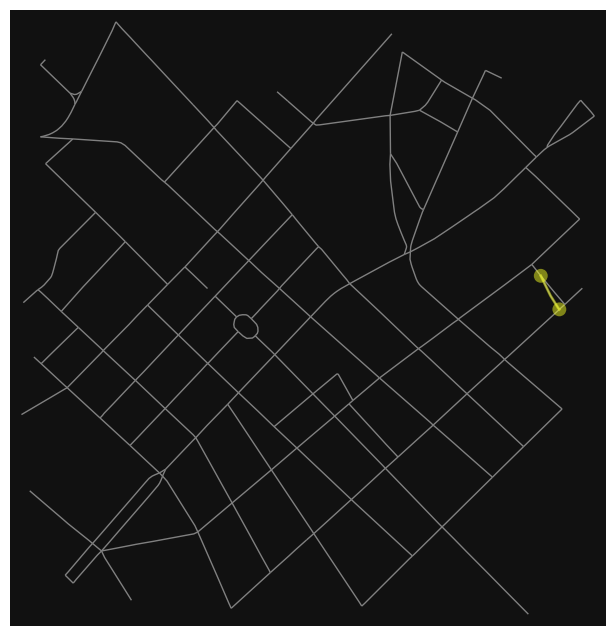

[(5132471525, 1199492691), (1199492691, 27585358), (27585358, 26609169), (26609169, 459995161), (459995161, 32860557), (32860557, 26609170), (26609170, 26609161), (26609161, 60586640), (60586640, 26609170), (26609170, 60586640), (60586640, 26609161), (26609161, 26609170), (26609170, 32860557), (32860557, 5091385368), (5091385368, 5134398694), (5134398694, 3504576142), (3504576142, 5134398694), (5134398694, 5091385368), (5091385368, 32860552), (32860552, 315809265), (315809265, 26678574), (26678574, 26656528), (26656528, 32860552), (32860552, 26656528), (26656528, 5134398653), (5134398653, 5134398652), (5134398652, 49241974), (49241974, 26678576), (26678576, 26609129), (26609129, 26639009), (26639009, 27023891), (27023891, 26639010), (26639010, 534396308), (534396308, 534396307), (534396307, 26639011), (26639011, 33425373), (33425373, 26639012), (26639012, 7886215587), (7886215587, 7886215593), (7886215593, 7886193583), (7886193583, 7886215594), (7886215594, 7886193583), (7886193583, 78

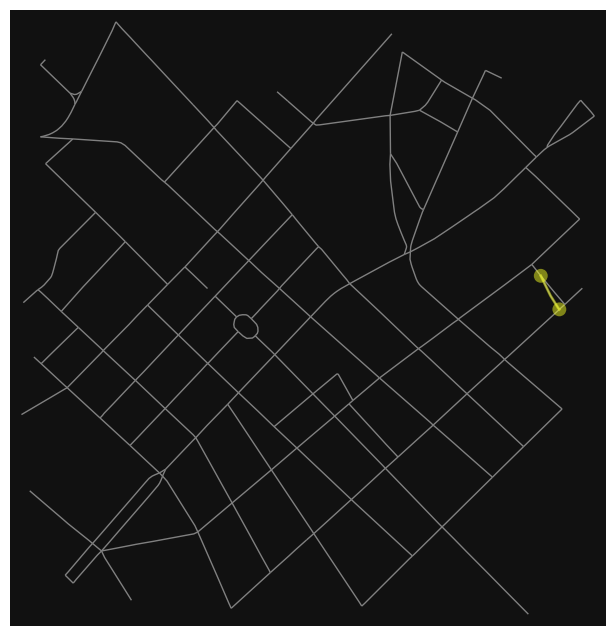


[Best graph GIF]


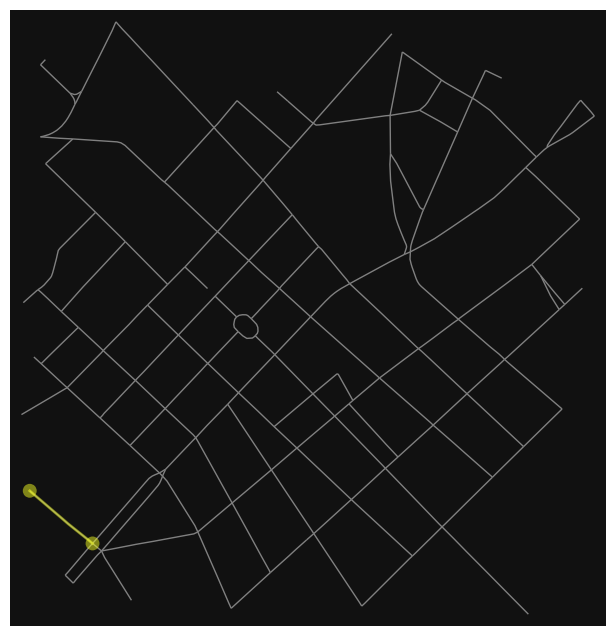

In [268]:
# Testing Nr3
# Radius from location = 800m
test_solver(3, 800, True)